*** 200000 1076.35
*** 400000 1076.35
*** 600000 1076.35


<ipython-input-1-c5fa5f2bb0ce>:150: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.subplot(1, len(qps_arr), i)


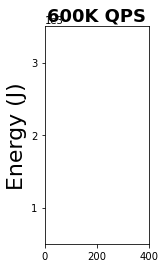

In [1]:
import pandas as pd
import numpy as np
#from mpl_toolkits.axes_grid.inset_locator import inset_axes
import matplotlib.pylab as plt
import matplotlib
import os
import glob
import multiprocessing as mp
import sys
import matplotlib.patches as mpatches

#plt.rc('axes', labelsize=18)    # fontsize of the x and y labels
#plt.rc('xtick', labelsize=18)    # fontsize of the tick labels
#plt.rc('ytick', labelsize=18)    # fontsize of the tick labels
#plt.rc('legend', fontsize=18)    # legend fontsize
#plt.rcParams['ytick.right'] = plt.rcParams['ytick.labelright'] = True
#plt.rcParams['ytick.left'] = plt.rcParams['ytick.labelleft'] = False

#plt.rcParams['figure.figsize'] = 14, 8

x_offset, y_offset = 0.01/5, 0.01/5

LINUX_COLS = ['i', 'rx_desc', 'rx_bytes', 'tx_desc', 'tx_bytes', 'instructions', 'cycles', 'ref_cycles', 'llc_miss', 'c1', 'c1e', 'c3', 'c6', 'c7', 'joules', 'timestamp']
EBBRT_COLS = ['i', 'rx_desc', 'rx_bytes', 'tx_desc', 'tx_bytes', 'instructions', 'cycles', 'ref_cycles', 'llc_miss', 'c3', 'c6', 'c7', 'joules', 'timestamp']

dvfs_dict = {
    "0xc00" :  1.2,
    "0xd00" :  1.3,
    "0xe00" :  1.4,
    "0xf00" :  1.5,
    "0x1000" : 1.6,
    "0x1100" : 1.7,
    "0x1200" : 1.8,
    "0x1300" : 1.9,
    "0x1400" : 2.0,
    "0x1500" : 2.1,
    "0x1600" : 2.2,
    "0x1700" : 2.3,
    "0x1800" : 2.4,
    "0x1900" : 2.5,
    "0x1a00" : 2.6,
    "0x1b00" : 2.7,
    "0x1c00" : 2.8,
    "0x1d00" : 2.9,
    "0xffff" : 3.0,
}

mqps_dict = {
    50000 : "50K QPS",
    100000 : "100K QPS",
    200000 : "200K QPS",
    400000 : "400K QPS",
    600000 : "600K QPS",
    1000000 : "1000K QPS",
    1500000 : "1500K QPS"
}

def updateDF(fname, START_RDTSC, END_RDTSC, ebbrt=False):
    df = pd.DataFrame()
    if ebbrt:
            df = pd.read_csv(fname, sep=' ', names=EBBRT_COLS, skiprows=1)
            df['c1'] = 0
            df['c1e'] = 0
    else:
        df = pd.read_csv(fname, sep=' ', names=LINUX_COLS)
                        ## filter out timestamps
        df = df[df['timestamp'] >= START_RDTSC]
        df = df[df['timestamp'] <= END_RDTSC]
        #converting timestamps
        df['timestamp'] = df['timestamp'] - df['timestamp'].min()
        df['timestamp'] = df['timestamp'] * TIME_CONVERSION_khz
        # update timestamp_diff
        df['timestamp_diff'] = df['timestamp'].diff()
        df.dropna(inplace=True)

    ## convert global_linux_tuned_df_non0j
    df_non0j = df[df['joules'] > 0
                    & (df['instructions'] > 0)
                & (df['cycles'] > 0)
                & (df['ref_cycles'] > 0)
                & (df['llc_miss'] > 0)].copy()
    df_non0j['timestamp_non0'] = df_non0j['timestamp'] - df_non0j['timestamp'].min()
    df_non0j['joules'] = df_non0j['joules'] * JOULE_CONVERSION
    tmp = df_non0j[['instructions', 'ref_cycles', 'cycles', 'joules', 'timestamp_non0', 'llc_miss', 'c1', 'c1e', 'c3', 'c6', 'c7']].diff()
    tmp.columns = [f'{c}_diff' for c in tmp.columns]
    df_non0j = pd.concat([df_non0j, tmp], axis=1)
    df_non0j['ref_cycles_diff'] = df_non0j['ref_cycles_diff'] * TIME_CONVERSION_khz
    df_non0j.dropna(inplace=True)
    df_non0j['nonidle_frac_diff'] = df_non0j['ref_cycles_diff'] / df_non0j['timestamp_non0_diff']
    return df, df_non0j

JOULE_CONVERSION = 0.00001526 #counter * constant -> JoulesOB
TIME_CONVERSION_khz = 1./(2899999*1000)

mcd_comb_loc='/Users/keli/symbiote_kernel/energy_trace_experiment_scripts/mcd/like/test_exper.csv'

COLORS = {'linux_default': 'blue',
          'linux_tuned': 'green',
	  'ebbrt_tuned': 'red',
	  'ebbrt_poll' : 'black'}
COLORS2 = {'linux_default': 'blue',
	   'linux_tuned': 'lime',
	   'ebbrt_tuned': 'red',
	   'ebbrt_poll' : 'black'}
LABELS = {'linux_default': 'Linux',
	  'linux_tuned': 'Linux-static',
	  'ebbrt_tuned': 'EbbRT-static',
	  'ebbrt_poll' : 'LibOS-poll'}
FMTS = {'linux_default':   'o--',
	'linux_tuned':   '*-.',
	'ebbrt_tuned':   'x:'}
LINES = {'linux_default':  '--',
	 'linux_tuned':   '-.',
	 'ebbrt_tuned':   ':'}
HATCHS = {'linux_default': 'X',
	  'linux_tuned':   '*',
	  'ebbrt_tuned':   'o',
	  'ebbrt_poll' :   'v'}

def read_workload(workload_loc):
    df = pd.read_csv(workload_loc, sep=' ')
    df = df[df['joules'] > 0]
    df = df[df['read_99th'] <= 500.0]
    df['edp'] = df['joules'] * df['read_99th']
    df['dvfs_orig'] = df['dvfs']
    df['dvfs'] = df['dvfs'].apply(lambda x: dvfs_dict[x])
    df['processor'] = df['dvfs'] * df['rapl']
    df['cpi'] = df['ref_cycles'] / df['instructions']
    df['ipc'] = df['instructions']/ df['ref_cycles']
    #df['cstate_exit_latency'] = ((df['c1']*2)+(df['c1e']*20)+(df['c3']*211)+(df['c6']*345)++(df['c7']*345))/1000000.0
    df['rx_desc_per_itr'] = df['rx_desc'] / df['num_interrupts']
    df['rx_bytes_per_itr'] = df['rx_bytes'] / df['num_interrupts']
    df['tx_desc_per_itr'] = df['tx_desc'] / df['num_interrupts']
    df['tx_bytes_per_itr'] = df['tx_bytes'] / df['num_interrupts']
    return df

def mcd_overview(df, qps_arr):
    i=1
    for QPS in qps_arr:
        print('***', QPS, df['joules'].max())
        dld = df[(df['sys']=='linux_default')
	     & (df['itr']==1)
	     & (df['dvfs']==3.0)
	     & (df['target_QPS'] == QPS)].copy()
        dlt = df[(df['sys']=='linux_tuned') & (df['target_QPS'] == QPS)].copy()
        #det = df[(df['sys']=='ebbrt_tuned') & (df['target_QPS'] == QPS)].copy()

        mssize=7
        # read_99th vs joules
        ax = plt.subplot(1, len(qps_arr), i)
        #plt.errorbar(det['read_99th'], det['joules'],
        #             fmt=HATCHS[det['sys'].max()], ms=mssize, c=COLORS[det['sys'].max()],
        #             label=LABELS[det['sys'].max()], alpha=.6)

    if dlt.shape[0] > 0:
        plt.errorbar(dlt['read_99th'], dlt['joules'],
                     fmt=HATCHS[dlt['sys'].max()], ms=mssize, c=COLORS[dlt['sys'].max()],
                     label=LABELS[dlt['sys'].max()], alpha=.6)

    if dld.shape[0] > 0:
        plt.errorbar(dld['read_99th'].mean(), dld['joules'].mean(),
                     fmt=HATCHS[dld['sys'].max()], ms=10, c=COLORS[dld['sys'].max()],
                     label=LABELS[dld['sys'].max()], alpha=1)

    if i == 1:
        plt.ylabel("Energy (J)", fontsize=22)
        plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))

    if i == 2:
        plt.xlabel("99% Tail Latency (usecs)", fontsize=22)

    #plt.text(200, 3150, mqps_dict[QPS], fontsize=24, bbox=dict(facecolor='white', alpha=0.5))
    plt.title(mqps_dict[QPS], fontsize=18, fontweight='bold')

    ## legend
    if i == 2:
        plt.legend(ncol=1, loc="lower left", fontsize=14)

    plt.xticks([0, 200, 400], [0, 200, 400])
    plt.ylim(ymin=500, ymax=3500)
    #plt.grid(True)
    if i > 1:
        ax.yaxis.set_ticklabels([])
        plt.tight_layout()
        i += 1

    plt.subplots_adjust(wspace=0.1, hspace=0)
    #plt.savefig('mcd_overview.pdf')

    plt.rcParams['figure.figsize'] = 14, 6

    plt.rc('xtick', labelsize=20)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=20)    # fontsize of the tick labels

workload_loc=mcd_comb_loc
df = read_workload(workload_loc)
mcd_overview(df, [200000, 400000, 600000])
